In [3]:
# installations

# !pip install numpy
# !pip install scipy
# !pip install math
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib

In [4]:
import importlib.util as import_util
import_util.find_spec('venv')

ModuleSpec(name='venv', loader=<_frozen_importlib_external.SourceFileLoader object at 0x10c97f110>, origin='/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/venv/__init__.py', submodule_search_locations=['/opt/homebrew/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/venv'])

In [5]:
# imports

import numpy as np
import scipy
import math

In [6]:
# secondary imports
import pandas as pd
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [7]:
def vamp_lasso(X, y, reg_lambda = 1, oracle_sigma2 = 1, max_iter = 100, tol = 1e-8, verbose = False) :

    # soft thresholding denoiser for lasso
    def soft_threshold(x, threshold):
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

    def subgradient_soft_threshold(r_1, threshold):
        grad = np.zeros_like(r_1)
        grad[np.abs(r_1) > threshold] = 1.0
        grad[np.isclose(np.abs(r_1), threshold)] = 0.75
        
        return grad

    n, p = X.shape
    delta_inv = p / n

    # initialization
    r_1 = np.random.normal(loc = 0, scale = 1, size = p)
    gamma_1 = 1

    # iterate
    for _ in range(max_iter) :
        
        # update beta_hat
        beta_hat = soft_threshold(r_1, reg_lambda/gamma_1)

        # check divergence
        if np.isnan(np.linalg.norm(beta_hat)) :
            print("divergence")
            return beta_hat

        # update b
        b = 1/p * np.sum(subgradient_soft_threshold(r_1, reg_lambda/gamma_1))

        # update eta 1
        eta_1 = gamma_1 / b
        
        # update gamma 2
        gamma_2 = eta_1 - gamma_1

        # update r_2
        r_2 = (1 / gamma_2) * (eta_1 * beta_hat - gamma_1 * r_1)

        # update c for gamma_1
        inv_arg = np.linalg.inv((1/oracle_sigma2) * X.T @ X + gamma_2 * np.eye(p))
        c = (1/p) * np.trace(gamma_2 * inv_arg)

        # update gamma_1
        gamma_1 = gamma_2 * (1/c - 1)

        # update r_1
        r_1 = (1 / (1-c)) * (inv_arg @ (1/oracle_sigma2 * X.T @ y + gamma_2 * r_2) - c * r_2)

    return beta_hat

In [8]:
def vamp_bayes(X, y, oracle_params = (1, 1), max_iter = 100, tol = 1e-8, verbose = False) :

    def f_denoiser(x, param) :
        return param * x

    n, p = X.shape
    delta_inv = p / n

    oracle_sigma2, oracle_tau2 = oracle_params

    # initialization
    r_1 = np.zeros(p)
    gamma_1 = 1

    # iterate
    for _ in range(max_iter) :
        
        # update denoiser param
        denoiser_param = (gamma_1 * oracle_tau2) / (gamma_1 * oracle_tau2 + 1)

        # update beta_hat
        beta_hat = denoiser_param * r_1

        # check divergence
        if np.isnan(np.linalg.norm(beta_hat)) :
            print("divergence")
            return beta_hat

        # update b
        b = denoiser_param

        # update eta 1
        eta_1 = gamma_1 / b
        
        # update gamma 2
        gamma_2 = eta_1 - gamma_1

        # update r_2
        r_2 = (1 / gamma_2) * (eta_1 * beta_hat - gamma_1 * r_1)

        # update c for gamma_1
        inv_arg = np.linalg.inv((1/oracle_sigma2) * X.T @ X + gamma_2 * np.eye(p))
        c = (1/p) * np.trace(gamma_2 * inv_arg)

        # update gamma_1
        gamma_1 = gamma_2 * (1/c - 1)

        # update r_1
        r_1 = (1 / (1-c)) * (inv_arg @ (1/oracle_sigma2 * X.T @ y + gamma_2 * r_2) - c * r_2)

    return beta_hat

In [9]:
# this cell is the Bayes AMP algorithm function

# X is design matrix, y is outcome, eta2 is initialization variance for beta_hat
# oracle_params are the known parameters for noise varianace and prior variance for beta_0 true
def amp_bayes(X, y, eta2 = 1, oracle_params = (1, 1), max_iter = 100, tol = 1e-8, verbose = False):

    def f_denoiser(x, sigma2_k, tau2) :
        return x * tau2 / (tau2 + sigma2_k)

    n, p = X.shape
    delta_inv = p / n

    oracle_sigma2, oracle_tau2 = oracle_params

    # initialization
    beta_hat = init_beta(p, "gaussian", var = eta2)
    r_hat = np.zeros(n)
    r_prev = np.zeros(n)
    b = 1

    # base case
    sigma2 = oracle_sigma2 + delta_inv * (oracle_tau2 + eta2)

    # iterate
    for _ in range(max_iter):

        # check divergence
        if np.isnan(np.linalg.norm(beta_hat)) :
            print("divergence")
            return beta_hat

        # update r_hat
        r_new = y - X @ beta_hat + b * r_hat

        # update sigma_k
        sigma2_new = oracle_sigma2 + delta_inv * (oracle_tau2 - (oracle_tau2 ** 2 / (oracle_tau2 + sigma2)))

        # update beta_hat
        denoiser_input = X.T @ r_new + beta_hat
        beta_new = f_denoiser(denoiser_input, sigma2_new, oracle_tau2)

        # update b
        b = p * oracle_tau2 / (n * (oracle_tau2 + sigma2_new))

        # store old iterate
        r_prev = r_hat
        r_hat = r_new

        sigma2_prev = sigma2
        sigma2 = sigma2_new

        # check convergence
        diff = np.linalg.norm(beta_hat - beta_new)
        if diff < tol * (np.linalg.norm(beta_hat) + 1e-12):
            beta_hat = beta_new

            if verbose :
                print("converged")
            break

        beta_hat = beta_new

    return beta_hat

In [53]:
# this cell is the AMP LASSO algorithm function

def amp_lasso(X, y, reg_lambda, max_iter = 500, tol = 1e-6):

    # soft thresholding denoiser for lasso
    def soft_threshold(x, threshold):
        return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)
    
    n, p = X.shape

    # initialization
    beta_hat = init_beta(p, "gaussian")
    r_hat = np.zeros(n)
    r_prev = np.zeros(n)

    # iterate
    for _ in range(max_iter):

        # check divergence
        if np.isnan(np.linalg.norm(beta_hat)) :
            print("divergence")
            return beta_hat

        # get the zero norm of beta_hat
        beta_norm_0 = np.count_nonzero(beta_hat)

        # update r_hat
        r_new = y - X @ beta_hat + (beta_norm_0 / n) * r_prev

        # get values for beta_hat update
        t_next = reg_lambda / (1 - (beta_norm_0 / n))

        # update beta_hat
        beta_new = soft_threshold(X.T @ r_new + beta_hat, t_next)

        # store old iterate
        r_prev = r_hat
        r_hat = r_new

        # check convergence
        diff = np.linalg.norm(beta_hat - beta_new)
        if diff < tol * (np.linalg.norm(beta_hat) + 1e-12):
            beta_hat = beta_new
            break

        beta_hat = beta_new

    return beta_hat

In [11]:
# this cell is the AMP iteration helpers

def init_beta(p, mean = 0, var = 1, method = "gaussian", scaling = 1) :
    if method == "gaussian" :
        beta_hat = np.random.normal(loc = 0, scale = math.sqrt(var), size = p)

    elif method == "zeros" :
        beta_hat = np.zeros(p)

    elif method == "ones" :
        beta_hat = scaling * np.ones(p)      
        
    elif method == "other" :
        print("not done yet 2")
        
    return beta_hat

In [12]:
# this cell is the data generation helpers

def generate_beta(p, mean = 0, var = 1, prior = "gaussian") :
    if prior == "gaussian" :
        beta = np.random.normal(loc = 0, scale = math.sqrt(var), size = p)

    elif prior == "sparse_gaussian" :
        print("not done yet 5")
        
    elif prior == "other" :
        print("not done yet 3")
    return beta

def generate_gaussian_design(n, p, symmetry = "asymmetric") :
    if symmetry == "symmetric" :
        if n != p :
            print("symmetric matrices need to have same row and column dimensions")
        else :
            print("not done yet 1")
    elif symmetry == "asymmetric" :
        matrix = np.random.normal(loc = 0, scale = 1 / math.sqrt(n), size = (n, p))
        
    else :
        print("invalid matrix type")
        
    return matrix

def generate_response(design_matrix, signal, noise_var) :
    n, p = design_matrix.shape
    error = np.random.normal(loc = 0, scale = math.sqrt(noise_var), size = n)

    return design_matrix @ signal + error

def generate_rri_design(n, p, k = -1, method = "lln") :
    if method == "lln" :
        if k == -1 :
            k = p
            
        X_1 = np.random.normal(loc = 0, scale = 1, size = (n, k))
        X_2 = np.random.normal(loc = 0, scale = 1, size = (k, k))
        X_3 = np.random.normal(loc = 0, scale = 1, size = (k, k))
        X_4 = np.random.normal(loc = 0, scale = 1, size = (k, p))
        
        X = (1 / math.sqrt(n)) * X_1 @ X_2 @ X_3 @ X_4

    if method == "heavy_tail" :
        df = 3
        mean = np.zeros(p)
        scale = np.eye(p)
        X = scipy.stats.multivariate_t.rvs(loc = mean, shape = scale, df = df, size = n)

    if method == "spiked" :
        X, V, W, signal, noise = generate_spiked(n, p)
        
    return X

def haar_orthonormal_columns(n, m):
    """
    Return an n x m matrix whose columns are m orthonormal vectors
    drawn from the Haar distribution (via QR of Gaussian matrix).
    """
    G = np.random.normal(size=(n, m))
    Q, R = np.linalg.qr(G)
    # fix sign indeterminacy so distribution is Haar
    signs = np.sign(np.diag(R))
    signs[signs == 0] = 1.0
    Q = Q * signs[np.newaxis, :]
    return Q

def generate_spiked(n, p, m=50, alpha=10.0, seed=None):
    """
    Generate X = alpha * V W^T + (1/n) * Z
    where V (n x m) and W (p x m) are Haar (orthonormal columns) and
    Z has iid N(0,1) entries (so noise entries ~ N(0, (1/n)^2)).
    Returns X, V, W, signal (alpha * V W^T), noise.
    """
    if m > min(n, p):
        raise ValueError("m must be <= min(n, p)")
    V = haar_orthonormal_columns(n, m)   # n x m
    W = haar_orthonormal_columns(p, m)   # p x m
    signal = alpha * (V @ W.T)                # n x p
    noise = (1.0 / math.sqrt(n)) * np.random.normal(size=(n, p))
    X = signal + noise
    return X, V, W, signal, noise

In [55]:
## FIRST, AMP LASSO. 
# THREE THINGS TO CHECK
    # matches LASSO solution
    # ASYMPTOTIC NORMALITY
    # check the phase transition for different values of delta

delta = 3.0

p = 100
n = int(delta * p)

sigma2 = 0.01

beta_bernnorm = np.random.binomial(1, 0.5, size = p) * generate_beta(p)
X_lamp = generate_gaussian_design(n, p)
y_lamp = generate_response(X_lamp, beta_bernnorm, sigma2)

lambda_lamp = 0.15
estimate_lamp = amp_lasso(X_lamp, y_lamp, lambda_lamp, max_iter = 25)

lasso_lambda = 1/n * lambda_lamp
lasso_model = Lasso(alpha = lasso_lambda)
lasso_model.fit(X_lamp, y_lamp)
estimate_lasso = lasso_model.coef_

compare_estimates_lamp = pd.DataFrame(np.array([beta_bernnorm, estimate_lamp, estimate_lasso]).T, columns = ['true_beta', 'lasso_amp_estimate', 'lasso_estimate'])
compare_estimates_lamp.round(4)

0.22499999999999998 1.6271185955757748
0.19823788546255508 0.7256631244395474
0.1939655172413793 0.8945207270600526
0.20089285714285715 1.1044261959732369
0.19736842105263158 1.2036714273045106
0.20361990950226244 1.5662523354008169
0.2054794520547945 1.9603338517046969
0.21327014218009477 2.65099360650197
0.2142857142857143 3.8043194380673886
0.2173913043478261 5.033624022024773
0.2173913043478261 8.894433225985217
0.21951219512195122 10.535045793564452
0.22277227722772278 21.845046281593486
0.2216748768472906 24.615845868820468
0.22388059701492538 54.5901234804649
0.22388059701492538 60.420037137760865
0.22499999999999998 138.6700310430844
0.22499999999999998 150.62184835722775
0.22499999999999998 355.92487693708887
0.22499999999999998 377.9317300822807
0.22499999999999998 920.2483606429995
0.22499999999999998 957.5871357033634
0.22499999999999998 2394.8488961945095
0.22499999999999998 2457.376627843553
0.22499999999999998 6270.2593622245


,true_beta,lasso_amp_estimate,lasso_estimate
0,0.4695,-4496.2130,0.1058
1,-0.3472,-1791.9359,-0.2756
2,-0.5617,2034.4444,-0.4148
3,-0.0000,1754.6501,0.0000
4,0.6878,-1184.7921,0.5410
...,...,...,...
95,0.0000,243.3770,0.0000
96,-0.5482,-147.9841,-0.3797
97,-0.0000,-6008.4427,0.0000
98,0.0000,1995.7208,0.0000


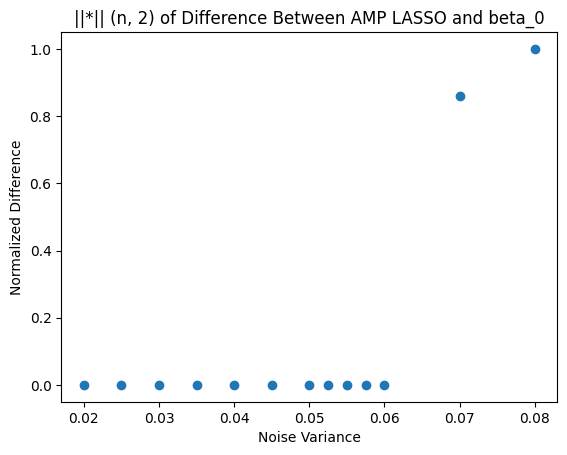

In [1123]:
# phase transition AMP LASSO vs true beta_0

delta = 5.0

p = 200
n = int(delta * p)

sigmas2 = [0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.0525, 0.055, 0.0575, 0.06, 0.07, 0.08]
error_diffs = []

for sigma2 in sigmas2 :

    errors = []

    for _ in range(50) :
        beta_bernnorm = np.random.binomial(1, 0.4, size = p) * generate_beta(p)
        X_lamp = generate_gaussian_design(n, p)
        y_lamp = generate_response(X_lamp, beta_bernnorm, sigma2)
        
        lambda_lamp = .15
        estimate_lamp = amp_lasso(X_lamp, y_lamp, lambda_lamp)
        
        lambda_lasso = 0.000145
        lasso = Lasso(alpha = lasso_lambda)
        lasso.fit(X_lamp, y_lamp)
        estimate_lasso = lasso.coef_
    
        errors.append(1/p * np.linalg.norm(beta_bernnorm - estimate_lamp))

    error_diffs.append(np.median(np.array(errors)))

error_diffs = 1/np.max(np.array(error_diffs)) * np.array(error_diffs)

plt.scatter(sigmas2, error_diffs)
plt.title("||*|| (n, 2) of Difference Between AMP LASSO and beta_0", size = 12)
plt.xlabel("Noise Variance")
plt.ylabel("Normalized Difference")
plt.show()

In [1168]:
## SECOND, AMP BAYES. 
# TWO THINGS TO CHECK
    # ASYMPTOTIC NORMALITY
    # check the phase transition for different values of delta

delta = 5.0

p = 200
n = int(delta * p)

sigma2 = 0.001
tau2 = 1

beta_norm = generate_beta(p)
X_bamp = generate_gaussian_design(n, p)
y_bamp = generate_response(X_bamp, beta_norm, sigma2)

estimate_bamp = amp_bayes(X_bamp, y_bamp, oracle_params = (sigma2, tau2), max_iter = 100)

compare_estimates_bamp = pd.DataFrame(np.array([beta_norm, estimate_bamp]).T, columns = ['true_beta', 'bayes_amp_estimate'])
compare_estimates_bamp.round(4)

,true_beta,bayes_amp_estimate
0,-0.2287,-0.2523
1,0.4742,0.4461
2,0.6411,0.6673
3,-0.0309,-0.0466
4,2.4970,2.4670
...,...,...
195,1.1224,1.1170
196,-1.5459,-1.5173
197,0.7047,0.6695
198,0.5429,0.5348


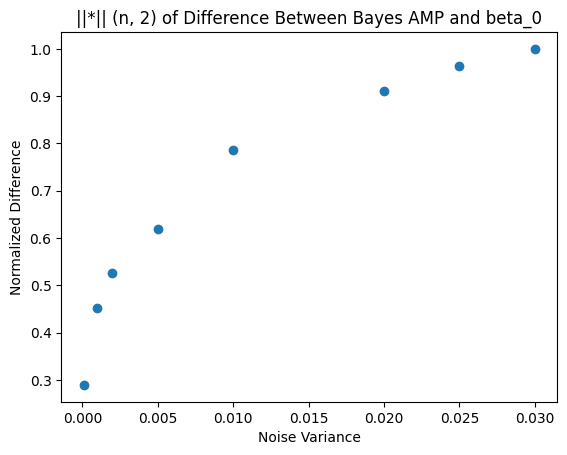

In [1150]:
# check phase transition

delta = 1.0

p = 200
n = int(delta * p)

sigmas2 = [0.0001, 0.001, 0.002, 0.005, 0.01, 0.02, 0.025, 0.03]
tau2 = 1

error_diffs = []

for sigma2 in sigmas2 :
    errors = []

    for _ in range(50) :
        beta_norm = generate_beta(p)
        X_bamp = generate_gaussian_design(n, p)
        y_bamp = generate_response(X_bamp, beta_norm, sigma2)
        
        estimate_bamp = amp_bayes(X_bamp, y_bamp, oracle_params = (sigma2, tau2), max_iter = 100)
        errors.append(1/p * np.linalg.norm(beta_norm - estimate_bamp))

    error_diffs.append(np.median(errors))

error_diffs = 1/np.max(np.array(error_diffs)) * np.array(error_diffs)

plt.scatter(sigmas2, error_diffs)
plt.title("||*|| (n, 2) of Difference Between Bayes AMP and beta_0", size = 12)
plt.xlabel("Noise Variance")
plt.ylabel("Normalized Difference")
plt.show()

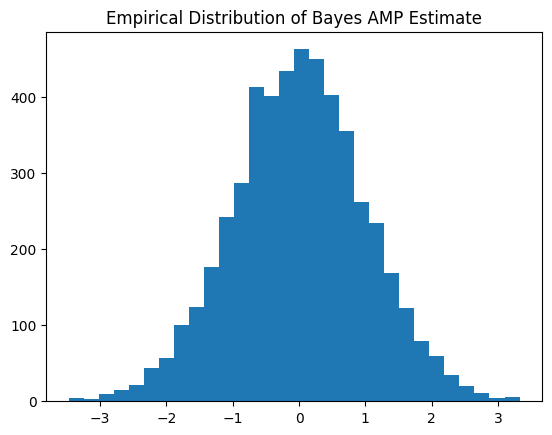

In [1192]:
# check asymptotic normality for bayes AMP

delta = 1.5

p = 5000
n = int(delta * p)

sigma2 = 0.001
tau2 = 1

beta_norm = generate_beta(p)
X_bamp = generate_gaussian_design(n, p)
y_bamp = generate_response(X_bamp, beta_norm, sigma2)

estimate_bamp = amp_bayes(X_bamp, y_bamp, oracle_params = (sigma2, tau2), max_iter = 100)

plt.hist(estimate_bamp, bins = 30)
plt.title("Empirical Distribution of Bayes AMP Estimate")
plt.show()

In [1264]:
# NOW, LASSO VAMP
# FOUR THINGS TO CHECK
    # matches LASSO solution
    # ASYMPTOTIC NORMALITY
    # check the phase transition for different values of delta
    # better than AMP for various RRI matrices

delta = 5.0

p = 200
n = int(delta * p)

sigma2 = 0.01

beta_bernnorm = np.random.binomial(1, 0.4, size = p) * generate_beta(p)
X_lvamp = generate_rri_design(n, p, method = "heavy_tail")
y_lvamp = generate_response(X_lvamp, beta_bernnorm, sigma2)

lambda_lamp = 0.15
lambda_lvamp = 1.0
estimate_lvamp = vamp_lasso(X_lvamp, y_lvamp, reg_lambda = lambda_lvamp)
estimate_lamp = amp_lasso(X_lvamp, y_lvamp, reg_lambda = lambda_lamp, max_iter = 1)

lambda_lasso = 0.00145
lasso = Lasso(alpha = lasso_lambda)
lasso.fit(X_lvamp, y_lvamp)
estimate_lasso = lasso.coef_

compare_estimates_lvamp = pd.DataFrame(np.array([beta_bernnorm, estimate_lvamp, estimate_lamp, estimate_lasso]).T, columns = ['true_beta', 'lasso_vamp_estimate', 'lasso_amp_estimate', 'lasso_estimate'])
compare_estimates_lvamp.round(4)

,true_beta,lasso_vamp_estimate,lasso_amp_estimate,lasso_estimate
0,0.0000,0.0000,3129.2521,0.0002
1,-0.0000,0.0002,3571.2943,0.0009
2,0.4159,0.4135,5563.5787,0.4138
3,0.0000,-0.0011,-827.1718,-0.0017
4,-0.0000,0.0000,-2028.7258,0.0009
...,...,...,...,...
195,0.0000,-0.0006,-3673.5110,-0.0006
196,0.0000,0.0052,-4637.5128,0.0059
197,-0.1723,-0.1706,-5843.5950,-0.1708
198,-0.0000,0.0011,-145.0795,0.0027


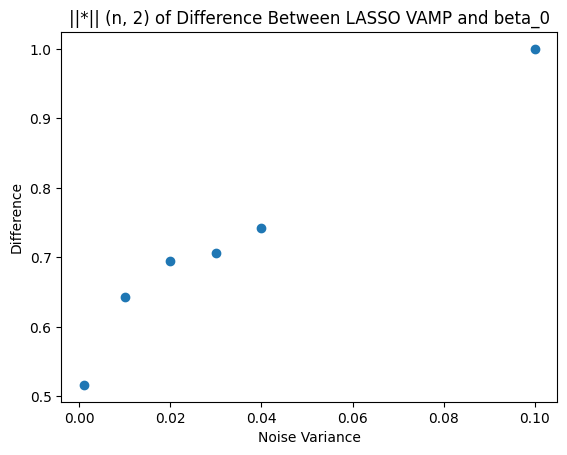

In [1322]:
# check phase transition of lasso VAMP

delta = .8

p = 200
n = int(delta * p)

sigmas2 = [0.001, 0.01, 0.02, 0.03, 0.04, 0.1]

error_diffs = []

for sigma2 in sigmas2 :
    errors = []

    for _ in range(50) :
        beta_bernnorm = np.random.binomial(1, 0.4, size = p) * generate_beta(p)
        X_lvamp = generate_rri_design(n, p, method = "heavy_tail")
        y_lvamp = generate_response(X_lvamp, beta_bernnorm, sigma2)
        
        lambda_lvamp = 1.0
        estimate_lvamp = vamp_lasso(X_lvamp, y_lvamp, reg_lambda = lambda_lvamp)

        errors.append(1/p * np.linalg.norm(estimate_lvamp - beta_bernnorm))
        
    error_diffs.append(np.median(errors))

error_diffs = 1/np.max(np.array(error_diffs)) * np.array(error_diffs)

plt.scatter(sigmas2, error_diffs)
plt.title("||*|| (n, 2) of Difference Between LASSO VAMP and beta_0", size = 12)
plt.xlabel("Noise Variance")
plt.ylabel("Difference")
plt.show()
plt.show()

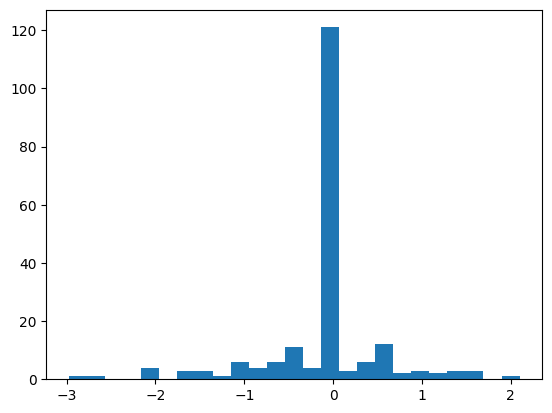

In [1268]:
# check asymptotic dist of lasso VAMP---not normal

delta = 5.0

p = 200
n = int(delta * p)

sigma2 = 0.01

beta_bernnorm = np.random.binomial(1, 0.4, size = p) * generate_beta(p)
X_lvamp = generate_rri_design(n, p, method = "heavy_tail")
y_lvamp = generate_response(X_lvamp, beta_bernnorm, sigma2)
estimate_lvamp = vamp_lasso(X_lvamp, y_lvamp, reg_lambda = lambda_lvamp)

plt.hist(estimate_lvamp, bins = 25)
plt.show()

In [1272]:
# NOW, Bayes VAMP
# THREE THINGS TO CHECK
    # ASYMPTOTIC NORMALITY
    # check the phase transition for different values of delta
    # better than AMP for various RRI matrices

delta = 5.0

p = 200
n = int(delta * p)

sigma2 = 0.01
tau2 = 1

beta_norm = generate_beta(p)
X_bvamp = generate_rri_design(n, p, method = "heavy_tail")
y_bvamp = generate_response(X_bvamp, beta_norm, sigma2)

estimate_bvamp = vamp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2))
estimate_bamp = amp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2), max_iter = 2)

compare_estimates_bvamp = pd.DataFrame(np.array([beta_norm, estimate_bvamp, estimate_bamp]).T, columns = ['true_beta', 'bayes_vamp_estimate', 'bayes_amp_estimate'])
compare_estimates_bvamp.round(4)

,true_beta,bayes_vamp_estimate,bayes_amp_estimate
0,-1.2416,-1.2431,-1.390031e+08
1,-1.4592,-1.4612,1.480109e+08
2,0.6001,0.6024,-1.505635e+08
3,-0.4543,-0.4572,2.164297e+08
4,1.4693,1.4703,-1.055389e+07
...,...,...,...
195,-2.1607,-2.1642,5.254715e+07
196,0.8336,0.8303,-2.702534e+08
197,0.9799,0.9836,-3.807008e+07
198,0.0805,0.0783,-6.488767e+07


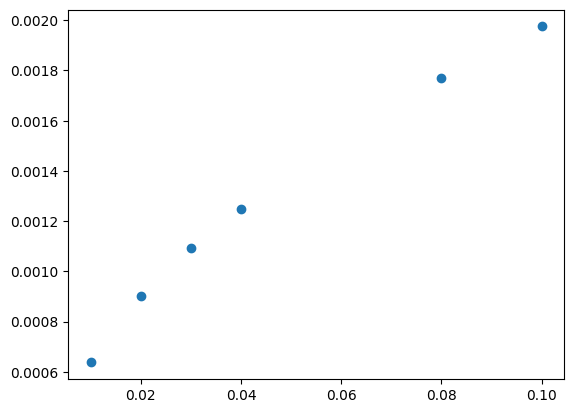

In [1288]:
# check for phase transition

delta = 1.5

p = 200
n = int(delta * p)

sigmas2 = [0.01, 0.02, 0.03, 0.04, 0.08, 0.1]
tau2 = 1

error_diff = []

for sigma2 in sigmas2 :
    errors = []

    for _ in range(50) :

        beta_norm = generate_beta(p)
        X_bvamp = generate_rri_design(n, p, method = "heavy_tail")
        y_bvamp = generate_response(X_bvamp, beta_norm, sigma2)
        
        estimate_bvamp = vamp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2))

        errors.append(1/p * np.linalg.norm(estimate_bvamp - beta_norm))
        
    error_diff.append(np.median(errors))

plt.scatter(sigmas2, error_diff)
plt.show()

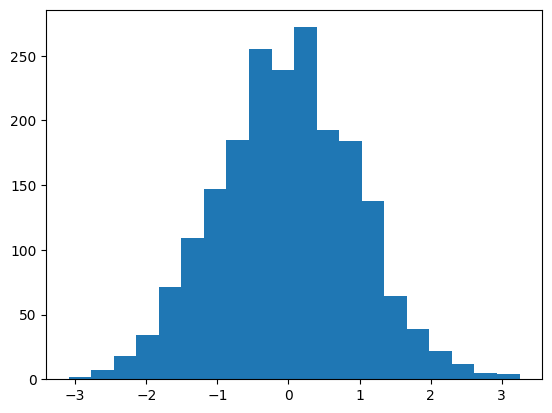

In [1332]:
# check asymptotic normality for bayes VAMP on RRI matrices

delta = 2.0

p = 2000
n = int(delta * p)

sigma2 = 0.01
tau2 = 1

beta_norm = generate_beta(p)
X_bvamp = generate_rri_design(n, p, method = "lln")
y_bvamp = generate_response(X_bvamp, beta_norm, sigma2)

estimate_bvamp = vamp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2))

plt.hist(estimate_bvamp, bins = 20)
plt.show()

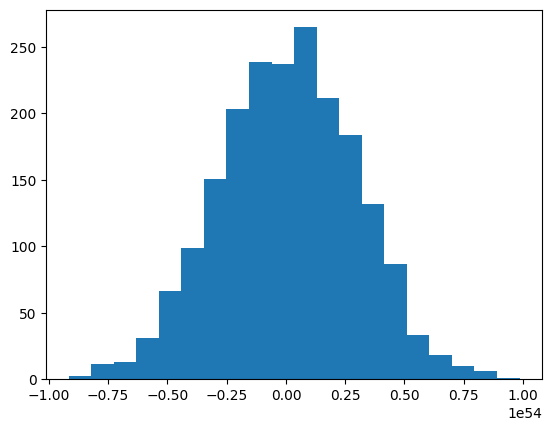

In [1333]:
# check asymptotic "normality" for bayes AMP on RRI matrices

estimate_bamp = amp_bayes(X_bvamp, y_bvamp, oracle_params = (sigma2, tau2), max_iter = 5)

plt.hist(estimate_bamp, bins = 20)
plt.show()

new_plot


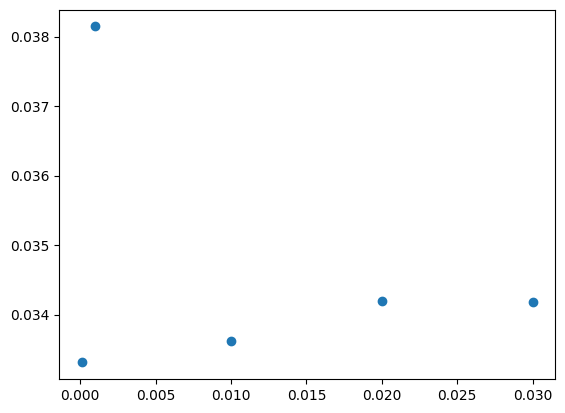

In [362]:
# amp_bayes(X, y, eta2 = 1, oracle_params = (1, 1), max_iter = 100000, tol = 1e-6)

delta = 0.6

p = 1000
n = int(delta * p)

mse = []

sigmas2 = [0.0001, 0.001, 0.01, 0.02, 0.03]

for sigma2 in sigmas2 :
    new_mse = []

    for _ in range(100) :

        tau2 = 1
        
        beta_true = generate_beta(p, var = tau2)
        X = generate_gaussian_design(n, p)
        y = generate_response(X, beta_true, noise_var = sigma2)
        
        b_amp = amp_bayes(X, y, eta2 = 1, oracle_params = (sigma2, tau2), max_iter = 100)
        new_mse.append(np.linalg.norm(b_amp - beta_true))

    avg_mse = np.mean(np.array(new_mse))
    mse.append(1 / n * avg_mse)

print('new_plot')
plt.scatter(sigmas2, y = mse)
plt.show()

In [ ]:
# amp_bayes(X, y, eta2 = 1, oracle_params = (*sigma2*, *tau2*), max_iter = 100000, tol = 1e-6)

n = 50000
p = 100000

mse = []

sigmas2 = [0.0001, 0.0002, 0.0003, 0.0004, 0.001, 0.01, 0.02]

for sigma2 in sigmas2 :
    new_mse = []

    for _ in range(1) :

        tau2 = 1
        
        beta_true = generate_beta(p, var = tau2)
        X = generate_gaussian_design(n, p)
        y = generate_response(X, beta_true, noise_var = sigma2)
        
        b_amp = amp_bayes(X, y, eta2 = 1, oracle_params = (sigma2, tau2), max_iter = 100000)
        new_mse.append(np.linalg.norm(b_amp - beta_true))

    avg_mse = np.median(np.array(new_mse))
    mse.append(1 / n * avg_mse)
    
plt.scatter(sigmas2, y = mse)
plt.xlim(-0.01, 0.025)
plt.ylim(0, 0.05)
plt.show()

In [657]:
# this cell is to check the divergence---why is it happening?

# amp_bayes(X, y, eta2 = 1, oracle_params = (*sigma2*, *tau2*), max_iter = 100000, tol = 1e-6)

n = 3000
p = 600

tau2 = 1
sigma2 = 0.1

for _ in range(10) :
    beta_true = generate_beta(p, var = tau2)
    X = generate_gaussian_design(n, p)
    y = generate_response(X, beta_true, noise_var = sigma2)
    b_amp = amp_bayes(X, y, eta2 = 1, oracle_params = (sigma2, tau2), max_iter = 100)

In [659]:
#b_amp = amp_bayes(X, y, eta2 = 1, oracle_params = (sigma2, tau2), max_iter = 10)
outputs = pd.DataFrame(np.array([beta_true, b_amp]).T, columns = ['true_beta', 'bayes_amp_estimate'])
outputs.round(4)

,true_beta,bayes_amp_estimate
0,-0.7020,-0.6899
1,0.9310,0.9735
2,0.6527,1.0100
3,0.9928,0.5999
4,-0.9905,-0.8761
...,...,...
595,0.9234,0.7117
596,0.1130,0.2104
597,0.2735,0.1119
598,-0.3959,-0.0799


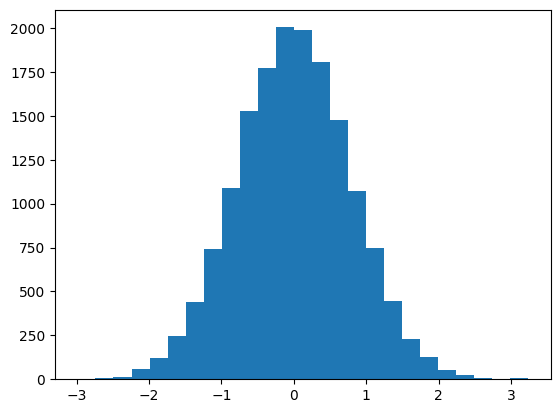

In [202]:
# this cell is to plot the distribution of the iterates for Bayes AMP

n = 10000
p = 16000

tau2 = 1
sigma2 = 0.01

beta_true = generate_beta(p, var = tau2)
X = generate_gaussian_design(n, p)
y = generate_response(X, beta_true, noise_var = sigma2)
beta = amp_bayes(X, y, eta2 = 1, oracle_params = (sigma2, tau2), max_iter = 100)

plt.hist(beta, bins = 25)
plt.show()

In [73]:
# this cell is to plot the distribution of the iterates for LASSO AMP

# LASSO AMP 
# WITH BERNOULLI/NORMAL MIX

betas = []

n = 1000
p = 5000

reg_lambda = 0.5
beta_true = generate_beta(p, mean = 0) # * np.random.binomial(1, 0.2, size = p)
X = generate_gaussian_design(n, p)
y = generate_response(X, beta_true, 0.01)

# plt.hist([val for val in beta if val != 0], bins = 20)
# plt.hist(beta, bins = 20)
# plt.show()

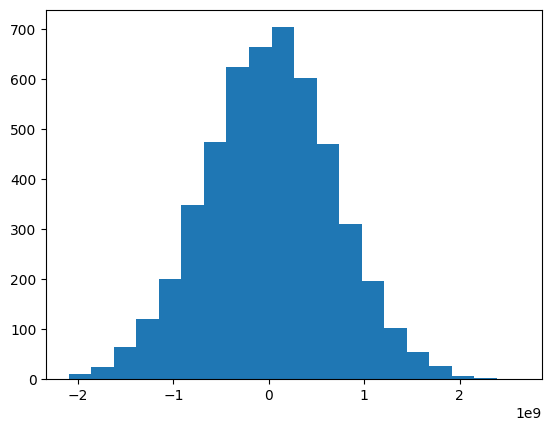

In [75]:
beta = amp_lasso(X, y, reg_lambda, max_iter = 10)

plt.hist([val for val in beta if val != 0], bins = 20)
#plt.hist(beta, bins = 20)
plt.show()

In [972]:
# this cell is to plot the distribution of the iterates for Bayes AMP

n = 1000
p = 900

tau2 = 1
sigma2 = 0.0001

beta_true = generate_beta(p, var = tau2)
X = generate_rri_design(n, p, method = "heavy_tail")
y = generate_response(X, beta_true, noise_var = sigma2)
beta_vamp = vamp_bayes(X, y, oracle_params = (sigma2, tau2), max_iter = 100, verbose = True)
beta_amp = amp_bayes(X, y, eta2 = 1, oracle_params = (sigma2, tau2), max_iter = 2)

outputs = pd.DataFrame(np.array([beta_true, beta_vamp, beta_amp]).T, columns = ['true_beta', 'bayes_vamp_estimate', "bayes_amp_estimate"])
outputs.round(4)

# plt.hist(beta_vamp, bins = 20)
# plt.show()

,true_beta,bayes_vamp_estimate,bayes_amp_estimate
0,0.2938,0.2938,4.727382e+08
1,-0.3444,-0.3449,1.608574e+08
2,-0.4303,-0.4283,1.088142e+09
3,-1.3702,-1.3728,-5.525810e+08
4,0.2490,0.2497,5.038305e+08
...,...,...,...
895,1.3631,1.3646,4.017266e+08
896,-0.4348,-0.4358,7.171118e+08
897,0.6239,0.6260,-3.934768e+08
898,-0.5085,-0.5085,1.105605e+09


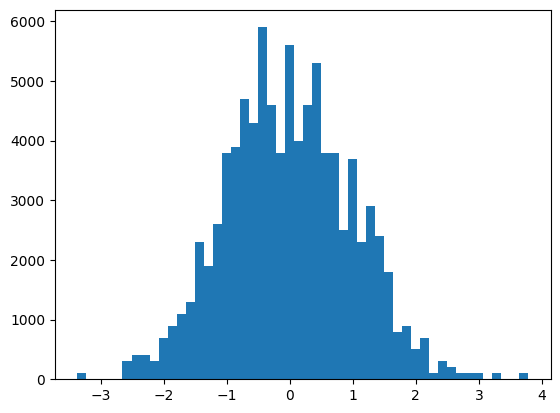

In [980]:
#plt.hist(beta_amp, bins = 25, alpha = 0.5)
estimates = []

for _ in range(100) :
    estimates.append(vamp_bayes(X, y, oracle_params = (sigma2, tau2), max_iter = 100, verbose = True))

plt.hist(np.array(estimates).flatten(), bins = 50, alpha = 1.0)
plt.show()

In [962]:
# this cell is to test the LASSO VAMP with bernoulli/gaussian mix prior

# LASSO AMP 
# WITH BERNOULLI/NORMAL MIX

n = 1000
p = 500

beta_true = np.random.binomial(1, 0.6, size = p) * generate_beta(p)
X = generate_rri_design(n, p, method = "heavy_tail")
y = generate_response(X, beta_true, 0.01)

reg_lambda = .2
lasso = Lasso(alpha=0.0018)
lasso.fit(X, y)

outputs = pd.DataFrame(np.array([beta_true, vamp_lasso(X, y, reg_lambda, max_iter = 100), amp_lasso(X, y, reg_lambda, max_iter = 2), lasso.coef_]).T, columns = ['true_beta', 'vamp_estimate', 'amp_estimate', 'lasso_estimate'])

outputs.round(4)

,true_beta,vamp_estimate,amp_estimate,lasso_estimate
0,0.7384,0.7404,-1.134209e+08,0.7390
1,0.2829,0.2797,-3.980966e+07,0.2789
2,2.0292,2.0257,4.734353e+07,2.0250
3,0.2501,0.2502,-3.543621e+07,0.2501
4,0.0000,-0.0013,-9.655005e+07,-0.0004
...,...,...,...,...
495,-0.0000,-0.0003,1.348944e+08,-0.0007
496,-0.9171,-0.9161,8.282965e+07,-0.9161
497,-0.0895,-0.0888,3.812215e+08,-0.0891
498,1.7354,1.7385,-1.183342e+08,1.7374


In [916]:
outputs = pd.DataFrame(np.array([beta_true, amp_lasso(X, y, reg_lambda, max_iter = 2), lasso.coef_]).T, columns = ['true_beta', 'vamp_estimate', 'lasso_estimate'])

outputs.round(4)

,true_beta,vamp_estimate,lasso_estimate
0,0.0000,-1.569499e+08,0.0007
1,-0.9324,8.875565e+07,-0.9312
2,-0.9575,6.624649e+07,-0.9568
3,0.0000,-5.922449e+07,-0.0011
4,0.2439,1.858423e+08,0.2413
...,...,...,...
195,-0.0000,3.977193e+07,-0.0013
196,1.5489,2.282842e+08,1.5437
197,1.3214,-1.691631e+08,1.3232
198,0.0000,5.382538e+07,0.0005


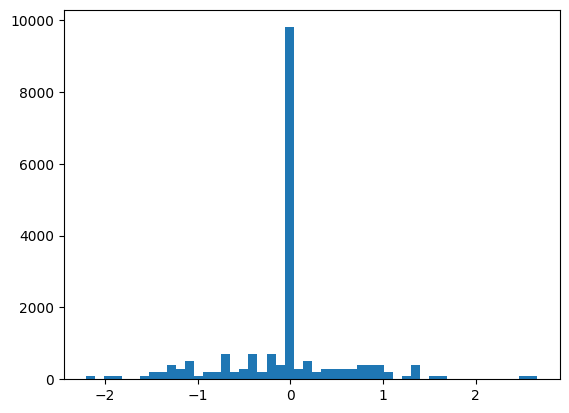

In [936]:
estimates = []

for _ in range(100) :
    estimates.append(vamp_bayes(X, y, max_iter = 20))

plt.hist(np.array(estimates).flatten(), bins = 50)
plt.show()